In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from sqlalchemy import func

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

from sqlcredentials import LOCAL_CREDENTIALS
import pymysql
pymysql.install_as_MySQLdb()

In [2]:
dialect = 'mysql'
user = LOCAL_CREDENTIALS["user"]  # 'root'
password = LOCAL_CREDENTIALS["password"]
host = 'localhost'
port = LOCAL_CREDENTIALS["port"]  # 3306
database = 'hawaii'

engine = create_engine(f'{dialect}://{user}:{password}@{host}:{port}'
                       f'/{database}')

In [3]:
Base = automap_base()

In [4]:
import warnings
warnings.filterwarnings("ignore")
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurements', 'stations']

In [6]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [7]:
session = Session(engine)

In [8]:
list(Measurements.__table__.columns)
# list(Stations.__table__.columns)

[Column('id', INTEGER(display_width=11), table=<measurements>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurements>),
 Column('date', TEXT(), table=<measurements>),
 Column('prcp', DOUBLE(asdecimal=True), table=<measurements>),
 Column('tobs', INTEGER(display_width=11), table=<measurements>)]

## Precipitation Analysis

In [9]:
dates = session.query(Measurements.date).order_by(Measurements.date.desc())
               
most_recent = dates.first()
most_recent

('2017-08-23')

In [10]:
results = (session
           .query(Measurements.date, Measurements.prcp)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date >= '2016-08-23')
           .all())
# results

In [11]:
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
# df.head

## Precipitation Analysis

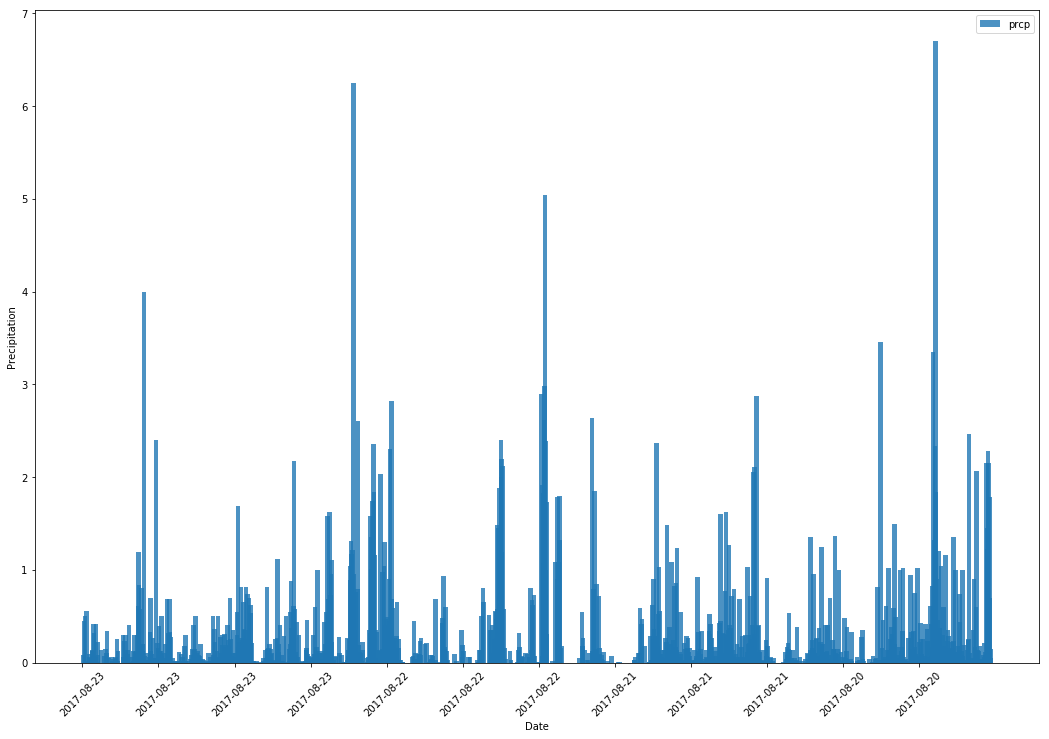

In [12]:
x_values = np.arange(len(df))

plt.figure(figsize=(18, 12))

plt.bar(x_values, df["prcp"], alpha=0.8, width=10)
plt.xticks(x_values, df.index.values, rotation=45)

plt.locator_params(nbins=12,axis='x')
plt.legend(df)
plt.ylabel("Precipitation")
plt.xlabel("Date")

plt.savefig("c_precipitation.png")
plt.show()

## Station Analysis

In [13]:
stations_total = (session
                   .query(Measurements.station)
                   .group_by(Measurements.station)
                   .count())
print(f'Numbers of staions: {stations_total}')

Numbers of staions: 9


In [14]:
stations_active = (session
                   .query(Measurements.station, func.count(Measurements.station))
                   .group_by(Measurements.station)
                   .order_by(func.count(Measurements.station).desc())
                   .all())
stations_active

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [15]:
most_active = stations_active[0]
print(f'The most active station is station {most_active[0]} with {most_active[1]} observations')

The most active station is station USC00519281 with 2772 observations


In [16]:
results1 = (session
           .query(Measurements.date, Measurements.tobs)
           .order_by(Measurements.date.desc())
           .filter(Measurements.station == 'USC00519281')
           .filter(Measurements.date >= '2016-08-23')
           .all())
results1

[('2017-08-18', 79),
 ('2017-08-17', 76),
 ('2017-08-16', 76),
 ('2017-08-15', 77),
 ('2017-08-14', 77),
 ('2017-08-13', 77),
 ('2017-08-06', 83),
 ('2017-08-05', 82),
 ('2017-08-04', 77),
 ('2017-07-31', 76),
 ('2017-07-30', 81),
 ('2017-07-29', 82),
 ('2017-07-28', 81),
 ('2017-07-27', 76),
 ('2017-07-26', 75),
 ('2017-07-25', 77),
 ('2017-07-24', 75),
 ('2017-07-23', 82),
 ('2017-07-22', 77),
 ('2017-07-21', 77),
 ('2017-07-20', 77),
 ('2017-07-19', 76),
 ('2017-07-18', 76),
 ('2017-07-17', 76),
 ('2017-07-16', 80),
 ('2017-07-15', 80),
 ('2017-07-14', 76),
 ('2017-07-13', 74),
 ('2017-07-12', 74),
 ('2017-07-11', 72),
 ('2017-07-10', 69),
 ('2017-07-09', 78),
 ('2017-07-08', 78),
 ('2017-07-07', 75),
 ('2017-07-06', 74),
 ('2017-07-05', 77),
 ('2017-07-04', 78),
 ('2017-07-03', 76),
 ('2017-07-02', 81),
 ('2017-07-01', 79),
 ('2017-06-30', 76),
 ('2017-06-29', 76),
 ('2017-06-28', 77),
 ('2017-06-27', 76),
 ('2017-06-26', 73),
 ('2017-06-25', 71),
 ('2017-06-24', 77),
 ('2017-06-23

In [17]:
df1 = pd.DataFrame(results1, columns=['date', 'tobs'])
df1.set_index('date', inplace=True, )
df1.head()

,tobs
date,
2017-08-18,79
2017-08-17,76
2017-08-16,76
2017-08-15,77
2017-08-14,77


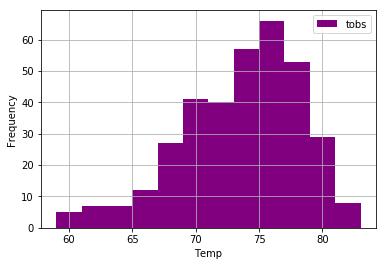

In [18]:
nbins = 12
x_values = df1['tobs']
plt.hist(x_values, nbins, color='purple')
plt.legend(df1)
plt.ylabel('Frequency')
plt.xlabel('Temp')
plt.savefig("c_station.png")
plt.grid()

plt.show()

## Temperature Analysis

In [19]:
start_date = '2017-03-23'
end_date = '2017-04-02'
def calc_temps (s, e):
    tmin = session.query(func.min(Measurements.tobs)).filter(Measurements.date >= s).filter(Measurements.date <= e).all()
    tavg = session.query(func.avg(Measurements.tobs)).filter(Measurements.date >= s).filter(Measurements.date <= e).all()
    tmax = session.query(func.max(Measurements.tobs)).filter(Measurements.date >= s).filter(Measurements.date <= e).all()
    
    return tmin, tavg, tmax
    
temp = calc_temps(start_date, end_date)
temp

([(68)], [(Decimal('74.5806'))], [(80)])

In [20]:
tmin = temp[0][0][0]
tavg = temp[1][0][0]
tmax = temp[2][0][0]
tp2p = tmax - tmin

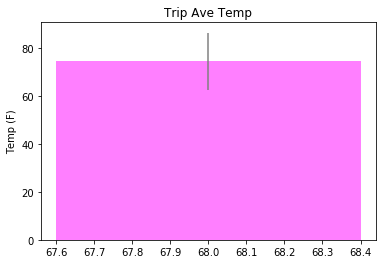

In [21]:
plt.bar(tmin, height=tavg, yerr=tp2p, alpha=0.5,
       color='magenta',
       error_kw=dict(ecolor='gray', capthick=5))
plt.title("Trip Ave Temp")
plt.ylabel("Temp (F)")
plt.margins(0.05)
plt.savefig("c_temp.png")
plt.show()